In [1]:
import numpy as np
import pandas as pd
import scanpy.api as sc
from scipy.misc import factorial
import os
import re

sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
#where to store?
#results_file = '/data/bioinf/projects/data/2018_sparse2big/RData/Retina-s3-sample.h5ad'
sc.settings.set_figure_params(dpi=80)

/global/apps/bioinf/conda_envs/scanpy/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/global/apps/bioinf/conda_envs/scanpy/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


scanpy==1.3.1 anndata==0.6.10 numpy==1.15.0 scipy==1.1.0 pandas==0.23.4 scikit-learn==0.19.1 statsmodels==0.9.0 python-igraph==0.7.1 louvain==0.6.1 


In [2]:
# Functions
## Pre-filter the data

In [3]:
def PreprocessSC(data_path, data_type):
    
    path = data_path
    
    # Build adata
    # var_names = HGNC symbols but adding ENSEMBLE gene IDs additionally
    # obs_names = Cell-IDs
    # -------------------------------------------------------------------- #
    global adata
    adata = sc.read(path + 'matrix.mtx', cache=True).T  # transpose the data
    genes = pd.read_csv(path + 'genes.tsv', header=None, sep='\t')
    adata.var_names = genes[1]
    adata.var['gene_ids'] = genes[0].tolist()  
    adata.obs_names = pd.read_csv(path + 'barcodes.tsv', header=None)[0]
    adata.var_names_make_unique()
    
    # -------------------------------------------------------------------- #
    # -------------------------------------------------------------------- #
    # Starting preprocessing
    # Highest expressed genes
    # -------------------------------------------------------------------- #
    sc.pl.highest_expr_genes(adata, n_top=20)
    
    # Filtering based on min. expressed genes per cell and vice versa
    sc.pp.filter_cells(adata, min_genes=200)
    sc.pp.filter_genes(adata, min_cells=3)
    
    # Prepare filtering for mitochondrial genes (based on HGNC)    
    # -------------------------------------------------------------------- #
    hgnc = [name for name in adata.var_names if name.startswith('MT-')]
    hgnc
    a = adata.var[adata.var_names.isin(hgnc)]
    mito_genes = a.index.values.tolist()
    adata.obs['percent_mito'] = np.sum(
        adata[:, mito_genes].X, axis=1).A1 / np.sum(adata.X, axis=1).A1
    adata.obs['n_counts'] = adata.X.sum(axis=1).A1
    
    # Save violin plot 
    # -------------------------------------------------------------------- #
    sc.pl.violin(adata, ['n_genes', 'n_counts', 'percent_mito'],
                 jitter=0.4, multi_panel=True, save = 'PT_Clust_Violin_Genes_Counts_Mito_' + str(data_type) + '.svg')
    
    # Plot scatter plots
    # -------------------------------------------------------------------- #
    sc.pl.scatter(adata, x='n_counts', y='percent_mito')
    sc.pl.scatter(adata, x='n_counts', y='n_genes')
    

In [4]:
## Extract filtered count data

In [5]:
def Extract_Count(adata_input, cutoff_mito, cutoff_ngenes, data_type):
    # Filter sc data
    # -----------------------------------------------------------------------
    global adata
    adata = adata_input
    adata = adata[adata.obs['n_genes'] < cutoff_ngenes, :]
    adata = adata[adata.obs['percent_mito'] < cutoff_mito, :]
    
    t=adata.X.toarray()
    pd.DataFrame(data=t, index=adata.obs_names, columns=adata.var_names).to_csv('/data/bioinf/projects/data/2019_schROHT/2021_Foveal_Peripheral_R/csvs/Count_data_schROHT_'+ str(data_type) +'.csv')

In [6]:
# Analysis
# HRO Control3

... reading from cache file ./cache/data-bioinf-projects-data-2018_scanpyTutorial-input-sc_hROHT-S3_CTRL_HRO2-raw_gene_bc_matrices-hg38.e87-matrix.h5ad
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
filtered out 343052 cells that have less than 1 counts


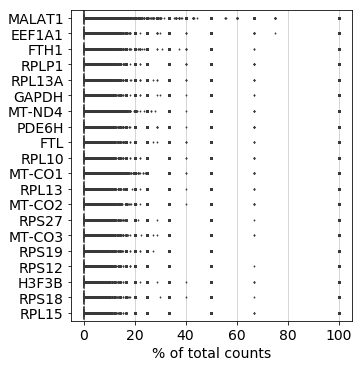

filtered out 728622 cells that have less than 200 genes expressed
filtered out 11909 genes that are detected in less than 3 cells
saving figure to file ./figures/violinPT_Clust_Violin_Genes_Counts_Mito_CTRL_3.svg


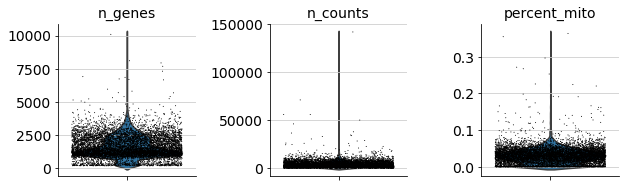

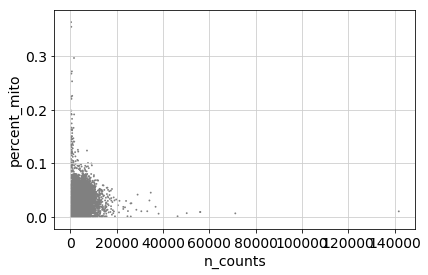

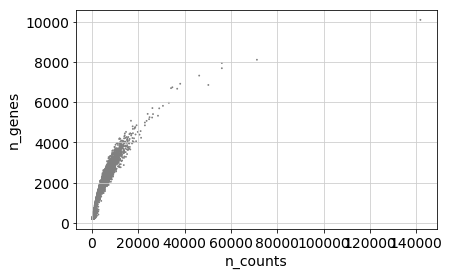

In [7]:
PreprocessSC(data_path = '/data/bioinf/projects/data/2018_scanpyTutorial/input/sc_hROHT/S3_CTRL_HRO2/raw_gene_bc_matrices/hg38.e87/',
             data_type = 'CTRL_3')

In [8]:
Extract_Count(adata_input = adata,
              cutoff_mito = 0.04, 
              cutoff_ngenes = 2500,
              data_type='Control3')

In [9]:
# HRO Control2

... reading from cache file ./cache/data-bioinf-projects-data-2018_scanpyTutorial-input-sc_hROHT-S2_CTRL_HRO1-outs-raw_gene_bc_matrices-hg38.e87-matrix.h5ad
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
filtered out 332278 cells that have less than 1 counts


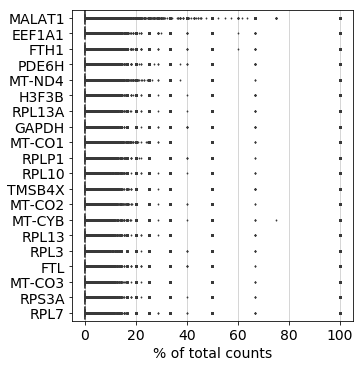

filtered out 727761 cells that have less than 200 genes expressed
filtered out 11292 genes that are detected in less than 3 cells
saving figure to file ./figures/violinPT_Clust_Violin_Genes_Counts_Mito_CTRL_2.svg


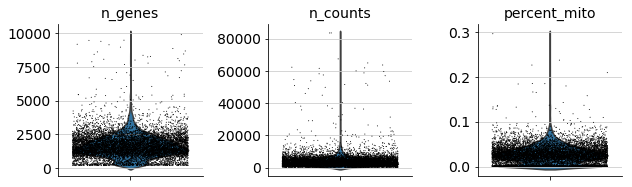

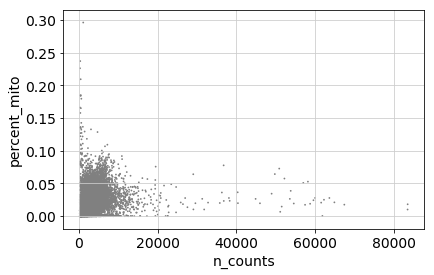

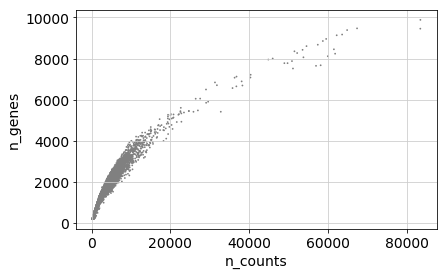

In [10]:
PreprocessSC(data_path = '/data/bioinf/projects/data/2018_scanpyTutorial/input/sc_hROHT/S2_CTRL_HRO1/outs/raw_gene_bc_matrices/hg38.e87/',
             data_type = 'CTRL_2')
Extract_Count(adata_input = adata, 
               cutoff_mito = 0.04, 
               cutoff_ngenes = 2500, 
               data_type = 'Control2')